<a href="https://colab.research.google.com/github/frostkose/MTE-Line-Balancing/blob/main/MTE4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Extract data from excel files

In [60]:
def tasks_exctraction(file_name="Equilibrage avec allure (3).xlsx",sheet_name="EQUILIBRAGE"):
    wb = load_workbook(file_name, data_only=True)
    sheet = wb[sheet_name]
    for row in sheet.iter_rows():
        for cell in row:
            if cell.value == "BF":
                BF = sheet.cell(row=cell.row, column=cell.column + 1).value
                #print(f"Valeur numérique à droite de 'BF': {BF}")
            elif cell.value=="Effectif:":
                Effectif = sheet.cell(row=cell.row, column=cell.column + 1).value
                #print(f"Valeur numérique à droite de 'Effectif:': {Effectif}")
            elif cell.value=="R% Cible ":
                R_cible = sheet.cell(row=cell.row, column=cell.column + 1).value
                #print(f"Valeur numérique à droite de 'R% Cible': {R_cible}")
            elif cell.value=="Prod Cible":
                Prod_cible = sheet.cell(row=cell.row, column=cell.column + 1).value
                #print(f"Valeur numérique à droite de 'Prod Cible': {Prod_cible}")
    noms_colonnes_attendus=["Operation"	,"POSTE"	 ,"Machine"	,"Prédécesseurs"	,	"TA"	,"Activité" ]
    for i, row in enumerate(sheet.iter_rows(values_only=True), start=1):
            if row is None:
                continue
            ligne = [str(cell).strip().lower() if cell else "" for cell in row]
            # Vérifie si tous les noms de colonnes attendus sont dans cette ligne
            if all(nom.lower() in ligne for nom in noms_colonnes_attendus):
                # Trouver l'index de la première cellule de l'en-tête
                col_start = ligne.index(noms_colonnes_attendus[0].lower())
                row_start = i - 1  # pandas est 0-indexé
                break
    else:
        raise ValueError(f"En-tête non trouvé ")


    #df = pd.read_excel("Equilibrage avec allure.xlsx",sheet_name="EQUILIBRAGE", header=row_start)
    df = pd.read_excel(file_name,sheet_name=sheet_name, header=row_start)
    #print(df)
    #df = df[[col for col in df.columns if col in noms_colonnes_attendus]]  # filtrer colonnes utiles
    #df
    nan_index = df[df.iloc[:, col_start].isna()].index

    if not nan_index.empty:
      first_nan_row = nan_index[0]
      df = df.loc[:first_nan_row - 1]
    #print(df)
    #if "JEU." in df.columns:
     # df = df.drop("JEU.", axis=1, errors='ignore')
    #if "FR" in df.columns:
     # df=df.drop("FR", axis=1, errors='ignore')
    #print(df)

    try:
        ta_col_index = df.columns.get_loc("TA")
    except KeyError:
        raise ValueError("Column 'TA' not found in the DataFrame.")

    df = df.iloc[:, :ta_col_index + 1]
    #print(df)


    data_n_2=df.copy()
    #print()
    data_n_2 = data_n_2.rename(columns={"Operation":"Libellé",
                                        "POSTE": "OPERATION",
                                        "Machine": "MACHINE",
                                      "Prédécesseurs":"PRED"})

    #data_n_2 = data_n_2.drop("Libellé", axis=1)
    data_n_2 = data_n_2.iloc[:-1]
    data_n_2['OPERATION'] = data_n_2['OPERATION'].apply(
    lambda x: str(int(x)) if isinstance(x, float) and x.is_integer() else str(x).strip()
    )
    #data_n_2['PRED']=data_n_2['PRED'].apply(lambda x: [] if pd.isna(x) else [item.strip() for item in str(x).split(',') if item.strip() != ''])
    #data_n_2['PRED']=data_n_2['PRED'].apply(lambda x: [] if pd.isna(x) else [int(float(item.strip())) for item in str(x).split(',') if item.strip() != ''])
    data_n_2['PRED'] = data_n_2['PRED'].apply(
    lambda x: [] if pd.isna(x) else [
        str(int(float(item.strip()))) if item.strip().replace('.', '', 1).isdigit() and float(item.strip()).is_integer()
        else item.strip()
        for item in str(x).split(',') if item.strip()
    ]
    )

    tasks={line['OPERATION']:{'predecessors': line['PRED'], 'duration': line['TA']} for _,line in data_n_2.iterrows()}
    #print("tasks: ",tasks)

    TA_total=sum([ v['duration'] for v in tasks.values()]) # cumul de temps des opérations
    #print('time_total :',TA_total)
    #cust_demand=Prod_cible #par semaine
    #open_days=open_days
    #working_time=working_time #heures de travail hors pauses
    #TT=working_time*60*open_days/cust_demand # calcul de Takt Time
    #-------------------------------------------------------------------------------------------
    #print('customer demand : ',Prod_cible)
    #print('BF : ',BF)
    #-----------------------------------------------------------------------------
    #num_operators=round(time_total/TT)
    #-----------------------------------------------------------------------------
    #print('nombre des effectifs :',Effectif)
    #print('R_cible :',R_cible)
    return {"BF":BF,"Prod_cible":Prod_cible,"Effectif":Effectif,"tasks":tasks,"R_cible":R_cible,"TA_total":TA_total}


# MTE balancing version 4


In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict, deque
import matplotlib.cm as cm
import openpyxl

class PrecedenceLineBalancing:
    def __init__(self, tasks, BF=15, num_workers=6, tolerance=0.2):
        self.tasks = tasks
        self.BF = BF
        self.tolerance = tolerance  # tolérance de dépassement
        self.num_workers = num_workers
        self.workstations = []
        self.workstation_times = []
        self.task_assigned = {}

    def topological_sort(self):
        graph = defaultdict(list)
        in_degree = defaultdict(int)

        for task, info in self.tasks.items():
            for pred in info['predecessors']:
                graph[pred].append(task)
                in_degree[task] += 1
            if task not in in_degree:
                in_degree[task] = 0

        queue = deque([node for node in in_degree if in_degree[node] == 0])
        sorted_tasks = []

        while queue:
            node = queue.popleft()
            sorted_tasks.append(node)
            for neighbor in graph[node]:
                in_degree[neighbor] -= 1
                if in_degree[neighbor] == 0:
                    queue.append(neighbor)

        if len(sorted_tasks) != len(self.tasks):
            raise ValueError("Cycle detected in task precedence!")

        return sorted_tasks

    def balance_line(self):
        sorted_tasks = self.topological_sort()
        max_allowed = self.BF * (1 + self.tolerance)

        for task in sorted_tasks:
            duration = self.tasks[task]['duration']

            # Cas spécial : si duration > max_allowed et proche de n * BF
            ratio = duration / self.BF
            n = round(ratio)
            if duration > max_allowed and abs(ratio - n) <= self.tolerance:
                for i in range(n):
                    self.workstations.append([(f"{task}_part{i+1}", duration / n)])
                    self.workstation_times.append(duration / n)
                self.task_assigned[task] = len(self.workstations) - 1
                continue

            # Essayer de l'affecter à un poste existant
            assigned = False
            for i in range(len(self.workstations)):
                new_total = self.workstation_times[i] + duration
                if new_total <= max_allowed:
                    if all(pred in self.task_assigned and self.task_assigned[pred] <= i
                           for pred in self.tasks[task]['predecessors']):
                        self.workstations[i].append((task, duration))
                        self.workstation_times[i] += duration
                        self.task_assigned[task] = i
                        assigned = True
                        break

            # Sinon, créer un nouveau poste
            if not assigned:
                self.workstations.append([(task, duration)])
                self.workstation_times.append(duration)
                self.task_assigned[task] = len(self.workstations) - 1
        return self.workstations,self.workstation_times

    def plot_distribution(self):
        labels = [f"Poste {i+1}" for i in range(len(self.workstations))]
        values = self.workstation_times

        #plt.figure(figsize=(10, 5))
        fig=plt.figure(figsize=(10, 5))
        #------------------------------------------------------------------------------<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        #cmap = cm.get_cmap('tab20')
        cmap = plt.get_cmap('tab20')
        color_map = {}
        color_index = 0

        bottom = np.zeros(len(self.workstations))
        for i, tasks in enumerate(self.workstations):
            for task, duration in tasks:
                if task not in color_map:
                    color_map[task] = cmap(color_index % 20)
                    color_index += 1
                plt.bar(labels[i], duration, bottom=bottom[i], color=color_map[task], label=task if task not in plt.gca().get_legend_handles_labels()[1] else "")
                bottom[i] += duration

        plt.axhline(y=self.BF, color='r', linestyle='--', label=f'Base de Temps (BF={self.BF:.2f})')

        for i, val in enumerate(values):
            plt.text(i, val + 0.2, f"{val:.2f}", ha='center', va='bottom')

        plt.title('Distribution des Temps avec contraintes de précédence (couleur unique par opération)')
        plt.xlabel('Postes de Travail')
        plt.ylabel('Temps (minutes)')
        plt.ylim(0, max(values + [self.BF]) + 2)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        #plt.show()
        plt.close()
        return fig #--------------------------------------------------------------<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    def display_assignment(self):
        print("\nRépartition des opérations :")
        for i, (ws, t) in enumerate(zip(self.workstations, self.workstation_times)):
            if ws:
                ops = [f"{task} ({dur:.2f} min)" for task, dur in ws]
                print(f"Poste {i+1} ({t:.2f} min): {', '.join(ops)}")
        #return (self.workstations,self.workstation_times)     #-----------------<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    def calculate_kpis(self):
        N = len(self.workstations)
        T_C = max(self.workstation_times) if N > 0 else 0
        total_time = sum(self.workstation_times)

        efficiency = total_time / (N * T_C) if T_C > 0 else 0
        smoothness = np.sqrt(sum((T_C - t) ** 2 for t in self.workstation_times))
        balance_delay = (N * T_C - total_time) / (N * T_C) if T_C > 0 else 0

        return {
            'Efficience maximale': round(efficiency * 100, 2),
            'Indice de fluidité (déséquilibre)': round(smoothness, 3),
            'Délai équilibrage (%)': round(balance_delay * 100, 2),
            'Temps de cycle': round(T_C, 3),
            'Postes utilisés': N
        }

    def export_results_to_excel(self,workstations, kpis, output_path="gamme_data.xlsx", sheet_name="Résultats_60511"):
      from openpyxl import load_workbook
      from openpyxl.utils import get_column_letter

      wb = load_workbook(output_path)
      if sheet_name in wb.sheetnames:
          del wb[sheet_name]
      ws = wb.create_sheet(sheet_name)

      ws.append(["Poste", "Tâche", "Durée (min)"])
      for i, ws_tasks in enumerate(workstations):
          for task, duration in ws_tasks:
              ws.append([f"Poste {i+1}", task, round(duration, 2)])

      ws.append([])
      ws.append(["KPI", "Valeur"])
      for k, v in kpis.items():
          ws.append([k, v])

      wb.save(output_path)

In [62]:
from openpyxl import load_workbook
#wb = load_workbook("Equilibrage avec allure.xlsx", data_only=True)
def mte_balance_by_file(file_name="Equilibrage avec allure (3).xlsx",open_days=6,working_time=7,sheet_name="EQUILIBRAGE"):

    BF,Prod_cible,Effectif,tasks,R_cible,TA_total=tasks_exctraction(file_name=file_name,sheet_name=sheet_name).values()
    balancer = PrecedenceLineBalancing(tasks, BF, num_workers=Effectif,tolerance=0.1)
    #balancer = PrecedenceLineBalancing(tasks_79615, BF=0.485, num_workers=num_operators,tolerance=0.05)
    ws,ws_t=balancer.balance_line()
    #balancer.display_assignment()
    fig=balancer.plot_distribution()

    kpis = balancer.calculate_kpis()
    #for k, v in kpis.items():
    #    print(f"{k} : {v}")
    return {"ws":ws,"wst":ws_t,"fig":fig,"kpis":kpis}


In [63]:
import networkx as nx

# Création du graphe dirigé
def graph_from_tasks(tasks):
    df = pd.DataFrame.from_dict(tasks, orient='index')
    df.index.name = 'Task'
    data_n_2 = df.reset_index()
    G = nx.DiGraph()

    # Ajouter les sommets
    for poste in data_n_2['OPERATION']:
        G.add_node(poste)

    # Ajouter les arêtes depuis PRED
    for index, row in data_n_2.iterrows():
        for pred in row['PRED']:
            G.add_edge(pred, row['OPERATION'])

    # Vérifier s’il y a un cycle
    if not nx.is_directed_acyclic_graph(G):
        print("❌ Cycle detected!")
        cycle = list(nx.simple_cycles(G))
        print("Cycle:", cycle)
    else:
        print("✅ Aucun cycle")
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G) # ou utilisez un autre layout comme nx.planar_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_weight='bold', arrowsize=20)
    plt.title('Graphe des opérations et de leurs prédécesseurs')
    plt.show()

#SPT

In [64]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

class SPTLineBalancer:
    def __init__(self, tasks: dict, bf: float):
        self.tasks = tasks
        self.BF = bf
        self.workstations = []
        self.workstation_times = []
        self.preds = {
        t: set(str(p).strip() for p in self.tasks[t]['predecessors']) if self.tasks[t]['predecessors'] else set()
        for t in self.tasks
        }

    def run(self):
        remaining_tasks = set(self.tasks.keys())
        assigned_tasks = set()
        durations = {t: self.tasks[t]['duration'] for t in self.tasks}
        #preds = {t: set(map(int, self.tasks[t]['predecessors'])) if self.tasks[t]['predecessors'] else set()
          #       for t in self.tasks}

        while remaining_tasks:
            ws_tasks = []
            ws_time = 0.0

            while True:
                # Tâches disponibles (dont tous les prédécesseurs sont déjà assignés)
                available = sorted(
                    [t for t in remaining_tasks #if preds[t].issubset(assigned_tasks)],
                    if self.preds[t].issubset(assigned_tasks)],
                    key=lambda x: durations[x]
                )

                if not available:
                    break

                added = False
                for t in available:
                    d = durations[t]
                    if ws_time + d <= self.BF:
                        ws_tasks.append((t, d))
                        ws_time += d
                        assigned_tasks.add(t)
                        remaining_tasks.remove(t)
                        added = True
                        break  # Reprendre la boucle while avec un nouveau available

                if not added:
                    break

            # Si aucune tâche n'a été ajoutée (mais certaines sont disponibles et trop longues), forcer une
            if not ws_tasks and available:
                t = available[0]
                d = durations[t]
                ws_tasks.append((t, d))
                ws_time += d
                assigned_tasks.add(t)
                remaining_tasks.remove(t)

            self.workstations.append(ws_tasks)
            self.workstation_times.append(ws_time)
        return self.workstations,self.workstation_times
    def plot_distribution(self):
        labels = [f"Poste {i+1}" for i in range(len(self.workstations))]
        values = self.workstation_times

        fig=plt.figure(figsize=(10, 5))
        #cmap = cm.get_cmap('tab20')
        cmap = plt.get_cmap('tab20')
        color_map = {}
        color_index = 0

        bottom = np.zeros(len(self.workstations))
        for i, tasks in enumerate(self.workstations):
            for task, duration in tasks:
                if task not in color_map:
                    color_map[task] = cmap(color_index % 20)
                    color_index += 1
                plt.bar(labels[i], duration, bottom=bottom[i], color=color_map[task],
                        label=task if task not in plt.gca().get_legend_handles_labels()[1] else "")
                bottom[i] += duration

        plt.axhline(y=self.BF, color='r', linestyle='--', label=f'Base de Temps (BF={self.BF:.2f})')

        for i, val in enumerate(values):
            plt.text(i, val + 0.1, f"{val:.2f}", ha='center', va='bottom')

        plt.title('Distribution SPT (avec contraintes de précédence)')
        plt.xlabel('Postes de Travail')
        plt.ylabel('Temps cumulé (minutes)')
        plt.ylim(0, max(values + [self.BF]) + 1)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        #plt.show()
        plt.close()
        return fig
    def display_assignment(self):
        print("\nRépartition des opérations (SPT) :")
        for i, (ws, t) in enumerate(zip(self.workstations, self.workstation_times)):
            if ws:
                ops = [f"{task} ({dur:.2f} min)" for task, dur in ws]
                print(f"Poste {i+1} ({t:.2f} min): {', '.join(ops)}")

    def compute_efficiency(self):
        total_task_time = sum(t['duration'] for t in self.tasks.values())
        num_stations = len(self.workstations)
        #return (total_task_time / (num_stations * self.BF)) * 100 if num_stations > 0 else 0
        return round((total_task_time / (num_stations * self.BF)) * 100,2) if num_stations > 0 else 0



    def compute_fluidity_index(self):
        max_time = max(self.workstation_times)
        #return sum((max_time - t)**2 for t in self.workstation_times)
        return round(sum((max_time - t)**2 for t in self.workstation_times),3)


In [65]:
def spt_balance_by_file(file_name="Equilibrage avec allure (3).xlsx",open_days=6,working_time=7,sheet_name="EQUILIBRAGE"):
    BF,Prod_cible,Effectif,tasks,R_cible,TA_total=tasks_exctraction(file_name=file_name).values()
    spt_balancer = SPTLineBalancer(tasks, BF)
    ws,ws_t=spt_balancer.run()
    #spt_balancer.display_assignment()
    fig=spt_balancer.plot_distribution()
    spt_eff = spt_balancer.compute_efficiency()
    spt_flu = spt_balancer.compute_fluidity_index()
    kpis={
        'Efficience maximale':spt_eff,
        'Indice de fluidité (déséquilibre)':spt_flu
    }
    #print(f"\n✅ Efficience : {spt_eff:.2f} %")
    #print(f"📉 Indice de déséquilibre : {spt_flu:.3f}")
    return {"ws":ws,"wst":ws_t,"fig":fig,"kpis":kpis}

#RPW

In [66]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

class RPWLineBalancer:
    def __init__(self, tasks: dict, bf: float):
        self.tasks = tasks
        self.BF = bf
        self.workstations = []
        self.workstation_times = []
        self.rpw_scores = {}

    def compute_rpw_scores(self):
        # Récursif : calcule le poids positionnel pour chaque tâche
        def rpw(task, memo):
            if task in memo:
                return memo[task]
            duration = self.tasks[task]['duration']
            #successors = [t for t in self.tasks if task in map(int, self.tasks[t]['predecessors'])]
            successors = [t for t in self.tasks if task in (str(p).strip() for p in self.tasks[t]['predecessors'])]
            total = duration + sum(rpw(s, memo) for s in successors)
            memo[task] = total
            return total

        memo = {}
        for t in self.tasks:
            self.rpw_scores[t] = rpw(t, memo)

    def run(self):
        self.compute_rpw_scores()
        remaining_tasks = set(self.tasks.keys())
        assigned_tasks = set()
        durations = {t: self.tasks[t]['duration'] for t in self.tasks}
        #preds = {t: set(map(int, self.tasks[t]['predecessors'])) if self.tasks[t]['predecessors'] else set()
         #        for t in self.tasks}
        self.preds = {
        t: set(str(p).strip() for p in self.tasks[t]['predecessors']) if self.tasks[t]['predecessors'] else set()
        for t in self.tasks
        }


        while remaining_tasks:
            ws_tasks = []
            ws_time = 0.0

            while True:
                # Tâches disponibles, triées par score RPW décroissant
                available = sorted(
                    [t for t in remaining_tasks #if preds[t].issubset(assigned_tasks)],
                    if self.preds[t].issubset(assigned_tasks)],
                     key=lambda x: self.rpw_scores[x],
                    reverse=True
                )

                if not available:
                    break

                added = False
                for t in available:
                    d = durations[t]
                    if ws_time + d <= self.BF:
                        ws_tasks.append((t, d))
                        ws_time += d
                        assigned_tasks.add(t)
                        remaining_tasks.remove(t)
                        added = True
                        break  # Reboucle while avec une mise à jour des available

                if not added:
                    break

            # Forcer la plus prioritaire si rien ne rentre
            if not ws_tasks and available:
                t = available[0]
                d = durations[t]
                ws_tasks.append((t, d))
                ws_time += d
                assigned_tasks.add(t)
                remaining_tasks.remove(t)

            self.workstations.append(ws_tasks)
            self.workstation_times.append(ws_time)
        return self.workstations,self.workstation_times

    def plot_distribution(self):
        labels = [f"Poste {i+1}" for i in range(len(self.workstations))]
        values = self.workstation_times

        fig=plt.figure(figsize=(10, 5))
        #cmap = cm.get_cmap('tab20')
        cmap = plt.get_cmap('tab20')
        color_map = {}
        color_index = 0

        bottom = np.zeros(len(self.workstations))
        for i, tasks in enumerate(self.workstations):
            for task, duration in tasks:
                if task not in color_map:
                    color_map[task] = cmap(color_index % 20)
                    color_index += 1
                plt.bar(labels[i], duration, bottom=bottom[i], color=color_map[task],
                        label=task if task not in plt.gca().get_legend_handles_labels()[1] else "")
                bottom[i] += duration

        plt.axhline(y=self.BF, color='r', linestyle='--', label=f'Base de Temps (BF={self.BF:.2f})')

        for i, val in enumerate(values):
            plt.text(i, val + 0.1, f"{val:.2f}", ha='center', va='bottom')

        plt.title('Distribution RPW (avec contraintes de précédence)')
        plt.xlabel('Postes de Travail')
        plt.ylabel('Temps cumulé (minutes)')
        plt.ylim(0, max(values + [self.BF]) + 1)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        #plt.show()
        plt.close()
        return fig
    def display_assignment(self):
        print("\nRépartition des opérations (RPW) :")
        for i, (ws, t) in enumerate(zip(self.workstations, self.workstation_times)):
            if ws:
                ops = [f"{task} ({dur:.2f} min)" for task, dur in ws]
                print(f"Poste {i+1} ({t:.2f} min): {', '.join(ops)}")

    def compute_efficiency(self):
        total_task_time = sum(t['duration'] for t in self.tasks.values())
        num_stations = len(self.workstations)
        #return (total_task_time / (num_stations * self.BF)) * 100 if num_stations > 0 else 0
        return round((total_task_time / (num_stations * self.BF)) * 100,2) if num_stations > 0 else 0

    def compute_fluidity_index(self):
        max_time = max(self.workstation_times)
        #return sum((max_time - t)**2 for t in self.workstation_times)
        return round(sum((max_time - t)**2 for t in self.workstation_times),3)


In [67]:
def rpw_balance_by_file(file_name="Equilibrage avec allure (3).xlsx",open_days=6,working_time=7,sheet_name="EQUILIBRAGE"):
    BF,Prod_cible,Effectif,tasks,R_cible,TA_total=tasks_exctraction(file_name=file_name).values()
    rpw_model = RPWLineBalancer(tasks, BF)
    ws,ws_t=rpw_model.run()
    #rpw_model.display_assignment()
    fig=rpw_model.plot_distribution()
    rpw_eff = rpw_model.compute_efficiency()
    rpw_flu = rpw_model.compute_fluidity_index()
    kpis={
        'Efficience maximale':rpw_eff,
        'Indice de fluidité (déséquilibre)':rpw_flu
    }
    #print(f"\n✅ Efficience : {rpw_eff:.2f} %")
    #print(f"📉 Indice de déséquilibre : {rpw_flu:.3f}")
    return {"ws":ws,"wst":ws_t,"fig":fig,"kpis":kpis}

#Bilan comparatif

In [68]:
import os
import pandas as pd

def read_methods_from_txt(txt_path):
    with open(txt_path, "r") as f:
        return [line.strip().upper() for line in f if line.strip()]

def compute_kpis_from_directory(directory_path, methods_txt_path):
    selected_methods = read_methods_from_txt(methods_txt_path)
    results = []

    for filename in os.listdir(directory_path):
        if filename.endswith(".xlsx") or filename.endswith(".xls"):
            file_path = os.path.join(directory_path, filename)
            row = {"Gamme": filename}

            try:
                #extraction = tasks_extraction(file_name=file_path)
                extraction=tasks_exctraction(file_path)#=file_path)
                tasks = extraction["tasks"]
                bf = extraction["BF"]

                if "MTE" in selected_methods:
                    try:
                        model_mte=mte_balance_by_file(file_path)
                        #model_mte = PrecedenceLineBalancing(tasks, BF=bf)
                        #model_mte.balance_line()
                        kpis_mte = model_mte["kpis"]
                        row["MTE - Efficience"] = kpis_mte['Efficience maximale']
                        row["MTE - Déséquilibre"] = kpis_mte['Indice de fluidité (déséquilibre)']
                    except Exception as e:
                        row["MTE - Efficience"] = f"Erreur: {e}"
                        row["MTE - Déséquilibre"] = "-"

                if "SPT" in selected_methods:
                    try:
                        model_spt=spt_balance_by_file(file_path)
                        #model_spt = SPTLineBalancer(tasks, bf)
                        #model_spt.run()
                        kpis_spt = model_spt["kpis"]
                        row["SPT - Efficience"] = kpis_spt['Efficience maximale']   #round(model_spt.compute_efficiency(), 2)
                        row["SPT - Déséquilibre"] =kpis_spt['Indice de fluidité (déséquilibre)']  #round(model_spt.compute_fluidity_index(), 3)
                    except Exception as e:
                        row["SPT - Efficience"] = f"Erreur: {e}"
                        row["SPT - Déséquilibre"] = "-"

                if "RPW" in selected_methods:
                    try:
                        model_rpw=rpw_balance_by_file(file_path)
                        #model_rpw = RPWLineBalancer(tasks, bf)
                        #model_rpw.run()
                        kpis_rpw = model_rpw["kpis"]
                        row["RPW - Efficience"] =kpis_rpw['Efficience maximale']  #round(model_rpw.compute_efficiency(), 2)
                        row["RPW - Déséquilibre"] = kpis_rpw['Indice de fluidité (déséquilibre)']    #round(model_rpw.compute_fluidity_index(), 3)
                    except Exception as e:
                        row["RPW - Efficience"] = f"Erreur: {e}"
                        row["RPW - Déséquilibre"] = "-"

            except Exception as e:
                row.update({f"{m} - Efficience": f"Erreur: {e}" for m in selected_methods})
                row.update({f"{m} - Déséquilibre": "-" for m in selected_methods})

            results.append(row)

    df = pd.DataFrame(results)
    return df


In [69]:
compute_kpis_from_directory("data","algo_list.txt")

/usr/local/lib/python3.11/dist-packages/openpyxl/reader/drawings.py:67: UserWarning: wmf image format is not supported so the image is being dropped
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/reader/drawings.py:67: UserWarning: wmf image format is not supported so the image is being dropped
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/reader/drawings.py:67: UserWarning: wmf image format is not supported so the image is being dropped
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/reader/drawings.py:67: UserWarning: wmf image format is not supported so the image is being dropped
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/reader/drawings.py:67: UserWarning: wmf image format is not supported so the image is being dropped
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/reader/drawings.py:67: UserWarning: wmf image format is not supported so the image is being dropped
  warn(msg)
/usr/local/lib/python3.11/dist-pac

,Gamme,MTE - Efficience,MTE - Déséquilibre
0,Equilibrage_61228(3).xlsx,84.44,0.250
1,Equilibrage_61228(2).xlsx,49.15,1.500
2,Equilibrage60511.xlsx,53.01,2.577
3,Equilibrage_79615.xlsx,68.12,0.510


In [70]:
import pandas as pd

def export_tableau_comparatif(df, output_path="comparatif_equilibrage.xlsx"):
    with pd.ExcelWriter(output_path, engine="xlsxwriter") as writer:
        df.to_excel(writer, sheet_name="Résultats", index=False)
    print(f"✅ Tableau exporté dans : {output_path}")


In [71]:
!pip install xlsxwriter

In [72]:
df=compute_kpis_from_directory("data","algo_list.txt")

/usr/local/lib/python3.11/dist-packages/openpyxl/reader/drawings.py:67: UserWarning: wmf image format is not supported so the image is being dropped
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/reader/drawings.py:67: UserWarning: wmf image format is not supported so the image is being dropped
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/reader/drawings.py:67: UserWarning: wmf image format is not supported so the image is being dropped
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/reader/drawings.py:67: UserWarning: wmf image format is not supported so the image is being dropped
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/reader/drawings.py:67: UserWarning: wmf image format is not supported so the image is being dropped
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/reader/drawings.py:67: UserWarning: wmf image format is not supported so the image is being dropped
  warn(msg)
/usr/local/lib/python3.11/dist-pac

In [73]:
export_tableau_comparatif(df,output_path="comparatif.xlsx")

✅ Tableau exporté dans : comparatif.xlsx


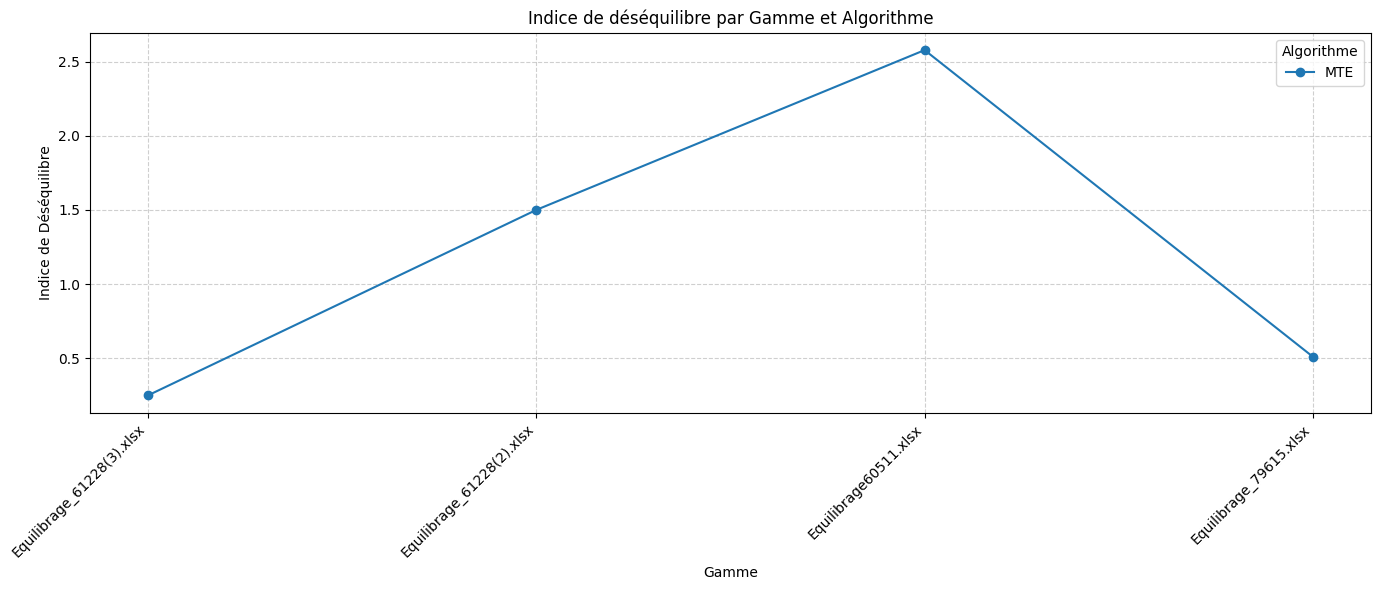

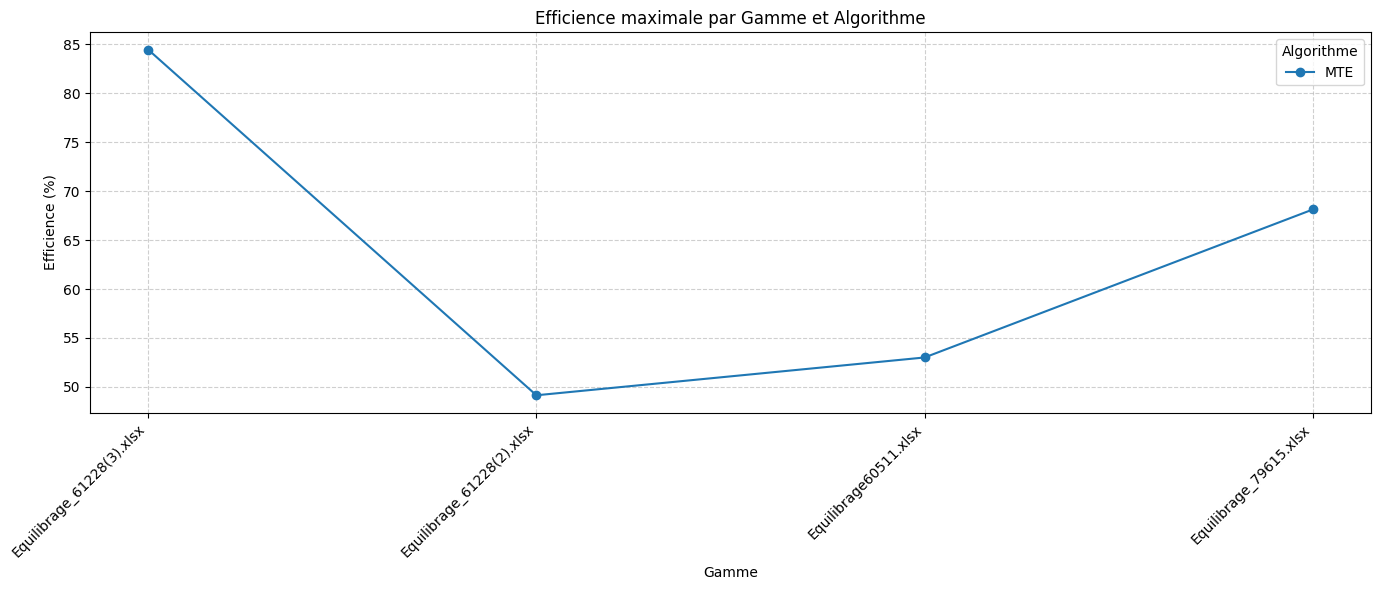

(<Figure size 1400x600 with 1 Axes>, <Figure size 1400x600 with 1 Axes>)

In [74]:

def plot_comparative_curves(df, output_path="comparatif.xlsx"):
    # Load the comparison table from the Excel file
    try:
        df = pd.read_excel(output_path)
    except FileNotFoundError:
        print(f"Error: File not found at {output_path}")
        return

    gammes = df["Gamme"]
    methods = [col.split(" - ")[0] for col in df.columns if " - " in col]
    unique_methods = sorted(list(set(methods)))

    # Prepare data for plotting
    efficiency_data = {method: [] for method in unique_methods}
    disbalance_data = {method: [] for method in unique_methods}
    common_methods = {}

    for _, row in df.iterrows():
        for method in unique_methods:
            eff_col = f"{method} - Efficience"
            dis_col = f"{method} - Déséquilibre"
            efficiency_data[method].append(row.get(eff_col, np.nan))
            disbalance_data[method].append(row.get(dis_col, np.nan))

    # Check for methods with identical results across all gammes
    for i in range(len(unique_methods)):
        for j in range(i + 1, len(unique_methods)):
            method1 = unique_methods[i]
            method2 = unique_methods[j]
            # Check if efficiency and disbalance are identical for all gammes
            eff_identical = all(
                (pd.isna(eff1) and pd.isna(eff2)) or (not pd.isna(eff1) and not pd.isna(eff2) and abs(eff1 - eff2) < 1e-9)
                for eff1, eff2 in zip(efficiency_data[method1], efficiency_data[method2])
            )
            dis_identical = all(
                (pd.isna(dis1) and pd.isna(dis2)) or (not pd.isna(dis1) and not pd.isna(dis2) and abs(dis1 - dis2) < 1e-9)
                for dis1, dis2 in zip(disbalance_data[method1], disbalance_data[method2])
            )

            if eff_identical and dis_identical:
                common_key = tuple(sorted((method1, method2)))
                if common_key not in common_methods:
                    common_methods[common_key] = []
                common_methods[common_key].append(method1) # Just need one representative for plotting
                common_methods[common_key].append(method2)


    # Remove methods that are part of a common group from the unique methods list for individual plotting
    plotted_methods = set()
    for group in common_methods.values():
        for m in group:
            plotted_methods.add(m)

    individual_methods_to_plot = [m for m in unique_methods if m not in plotted_methods]


    # Plotting the Déséquilibre (Fluidity Index)
    fig_des=plt.figure(figsize=(14, 6))
    x_positions = np.arange(len(gammes)) # Use numerical positions for plotting points

    # Plot individual methods
    for method in individual_methods_to_plot:
        plt.plot(x_positions, disbalance_data[method], marker='o', linestyle='-', label=method)

    # Plot methods with identical results using potentially a different marker/color if needed
    # Here, we'll just plot one line for the common group and label it appropriately
    for common_group_tuple, methods_in_group in common_methods.items():
        # Use the first method in the group to get the data
        representative_method = methods_in_group[0]
        label = f"{'/'.join(methods_in_group)} (Identique)"
        plt.plot(x_positions, disbalance_data[representative_method], marker='s', linestyle='--', label=label) # Use a different marker and linestyle

    plt.xticks(x_positions, gammes, rotation=45, ha='right')
    plt.title('Indice de déséquilibre par Gamme et Algorithme')
    plt.xlabel('Gamme')
    plt.ylabel('Indice de Déséquilibre')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='Algorithme')
    plt.tight_layout()
    plt.show()

    # Plotting the Efficience
    fig_eff=plt.figure(figsize=(14, 6))
    # Use numerical positions for plotting points

    # Plot individual methods
    for method in individual_methods_to_plot:
         plt.plot(x_positions, efficiency_data[method], marker='o', linestyle='-', label=method)

     # Plot methods with identical results using potentially a different marker/color if needed
    for common_group_tuple, methods_in_group in common_methods.items():
         representative_method = methods_in_group[0]
         label = f"{'/'.join(methods_in_group)} (Identique)"
         plt.plot(x_positions, efficiency_data[representative_method], marker='s', linestyle='--', label=label) # Use a different marker and linestyle


    plt.xticks(x_positions, gammes, rotation=45, ha='right')
    plt.title('Efficience maximale par Gamme et Algorithme')
    plt.xlabel('Gamme')
    plt.ylabel('Efficience (%)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='Algorithme')
    plt.tight_layout()
    plt.show()
    return fig_des,fig_eff
# Assuming 'comparatif.xlsx' is generated and saved from the previous step
# Call the plotting function
plot_comparative_curves(df, output_path="comparatif.xlsx")



#plot solution


In [92]:
def plot_distribution_on_axis(method,ax, bf,title):
    labels = [f"Poste {i+1}" for i in range(len(method["ws"]))]
    values = method["wst"]

    ax.clear() # Clear previous content from the axis

    #cmap = cm.get_cmap('tab20')
    cmap = plt.get_cmap('tab20')
    color_map = {}
    color_index = 0

    bottom = np.zeros(len(method["ws"]))
    for i, tasks in enumerate(method["ws"]):
        for task, duration in tasks:
            if task not in color_map:
                color_map[task] = cmap(color_index % 20)
                color_index += 1
            ax.bar(labels[i], duration, bottom=bottom[i], color=color_map[task], label=task if task not in [h.get_label() for h in ax.get_legend_handles_labels()[0]] else "")
            bottom[i] += duration

    ax.axhline(y=bf, color='r', linestyle='--', label=f'BF={bf:.2f}')

    for i, val in enumerate(values):
        ax.text(i, val + 0.1, f"{val:.2f}", ha='center', va='bottom', fontsize=8) # Smaller font for labels

    ax.set_title(title, fontsize=10) # Smaller font for title
    ax.set_xlabel('Postes', fontsize=8) # Smaller font for labels
    ax.set_ylabel('Temps (min)', fontsize=8) # Smaller font for labels
    ax.set_ylim(0, max(values + [bf]) + 1)
    ax.tick_params(axis='both', which='major', labelsize=8) # Smaller tick labels
    # Place legend outside the plot if it's too big
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7)
PrecedenceLineBalancing.plot_distribution_on_axis = plot_distribution_on_axis
SPTLineBalancer.plot_distribution_on_axis = plot_distribution_on_axis
RPWLineBalancer.plot_distribution_on_axis = plot_distribution_on_axis


In [93]:
def plot_all_methods_by_file(file_name="Equilibrage avec allure (3).xlsx",methods_txt_path="algo_list.txt"):
    selected_methods = read_methods_from_txt(methods_txt_path)
    print(f"\nProcessing file: {file_name}")
    fig=None
    try:
            # Extract data
            extraction = tasks_exctraction(file_name)
            tasks = extraction["tasks"]
            bf = extraction["BF"]

            # Determine number of plots for this file
            num_plots = len(selected_methods)
            if num_plots == 0:
                print(f"No algorithms selected for {file_name}.")
                return

            # Create a single figure with subplots arranged side-by-side
            fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 6), squeeze=False)
            axes = axes.flatten() # Flatten the 2D array of axes for easy indexing

            plot_index = 0

            if "MTE" in selected_methods:
                try:
                    model_mte=mte_balance_by_file(file_name)
                    #model_mte = PrecedenceLineBalancing(tasks, BF=bf)
                    #model_mte.balance_line()
                    # Plot on the first available axis
                    plot_distribution_on_axis(model_mte,axes[plot_index], bf,f"MTE - {file_name}")
                    plot_index += 1
                except Exception as e:
                    print(f"Error running MTE for {file_name}: {e}")
                    axes[plot_index].set_title(f'MTE - {file_name}\nError')
                    axes[plot_index].axis('off') # Turn off axis if there's an error
                    plot_index += 1


            if "SPT" in selected_methods:
                try:
                    model_spt=spt_balance_by_file(file_name)
                    #model_spt = SPTLineBalancer(tasks, bf)
                    #model_spt.run()
                    # Plot on the next available axis
                    plot_distribution_on_axis(model_spt,axes[plot_index],bf, f"SPT - {file_name}")
                    plot_index += 1
                except Exception as e:
                    print(f"Error running SPT for {file_name}: {e}")
                    axes[plot_index].set_title(f'SPT - {file_name}\nError')
                    axes[plot_index].axis('off')
                    plot_index += 1


            if "RPW" in selected_methods:
                try:
                    model_rpw=rpw_balance_by_file(file_name)
                    #model_rpw = RPWLineBalancer(tasks, bf)
                    #model_rpw.run()
                    # Plot on the next available axis
                    plot_distribution_on_axis(model_rpw,axes[plot_index], bf,f"RPW - {file_name}")
                    plot_index += 1
                except Exception as e:
                    print(f"Error running RPW for {file_name}: {e}")
                    axes[plot_index].set_title(f'RPW - {file_name}\nError')
                    axes[plot_index].axis('off')
                    plot_index += 1

            # Hide any unused subplots
            for i in range(plot_index, num_plots):
                axes[i].axis('off')

            plt.tight_layout()
            #plt.show()
            plt.close()

    except Exception as e:
        print(f"Error processing file {file_name}: {e}")
    return fig





Processing file: data/Equilibrage_61228(2).xlsx


/usr/local/lib/python3.11/dist-packages/openpyxl/reader/drawings.py:67: UserWarning: wmf image format is not supported so the image is being dropped
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/reader/drawings.py:67: UserWarning: wmf image format is not supported so the image is being dropped
  warn(msg)


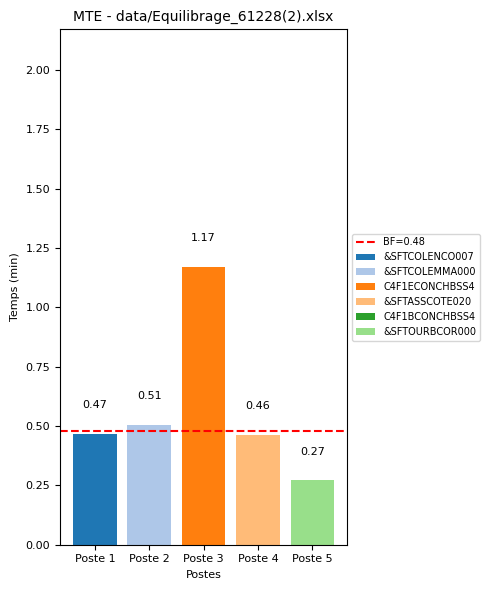

In [94]:
plot_all_methods_by_file(file_name="data/Equilibrage_61228(2).xlsx",methods_txt_path="algo_list.txt")


Processing file: Equilibrage_61228(3).xlsx


/usr/local/lib/python3.11/dist-packages/openpyxl/reader/drawings.py:67: UserWarning: wmf image format is not supported so the image is being dropped
  warn(msg)
<ipython-input-84-1755139924>:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')



Processing file: Equilibrage_61228(2).xlsx


/usr/local/lib/python3.11/dist-packages/openpyxl/reader/drawings.py:67: UserWarning: wmf image format is not supported so the image is being dropped
  warn(msg)
<ipython-input-84-1755139924>:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')



Processing file: Equilibrage60511.xlsx


/usr/local/lib/python3.11/dist-packages/openpyxl/reader/drawings.py:67: UserWarning: wmf image format is not supported so the image is being dropped
  warn(msg)
<ipython-input-84-1755139924>:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')



Processing file: Equilibrage_79615.xlsx


/usr/local/lib/python3.11/dist-packages/openpyxl/reader/drawings.py:67: UserWarning: wmf image format is not supported so the image is being dropped
  warn(msg)
<ipython-input-84-1755139924>:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')


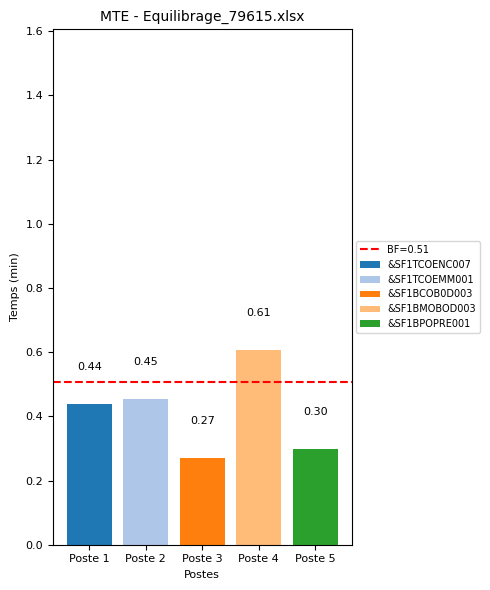

In [84]:
def plot_all_solutions(directory_path="data", methods_txt_path="algo_list.txt"):
    """
    Plots the solution distribution for every file in a directory
    using specified algorithms, displaying figures side-by-side.
    """
    selected_methods = read_methods_from_txt(methods_txt_path)

    # Get list of data files
    data_files = [f for f in os.listdir(directory_path) if f.endswith((".xlsx", ".xls"))]
    fig=None
    for filename in data_files:
        file_path = os.path.join(directory_path, filename)
        print(f"\nProcessing file: {filename}")

        try:
            # Extract data
            extraction = tasks_exctraction(file_name=file_path)
            tasks = extraction["tasks"]
            bf = extraction["BF"]

            # Determine number of plots for this file
            num_plots = len(selected_methods)
            if num_plots == 0:
                print(f"No algorithms selected for {filename}.")
                continue

            # Create a single figure with subplots arranged side-by-side
            fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 6), squeeze=False)
            axes = axes.flatten() # Flatten the 2D array of axes for easy indexing

            plot_index = 0

            if "MTE" in selected_methods:
                try:
                    model_mte = PrecedenceLineBalancing(tasks, BF=bf)
                    model_mte.balance_line()
                    # Plot on the first available axis
                    model_mte.plot_distribution_on_axis(axes[plot_index], title=f'MTE - {filename}')
                    plot_index += 1
                except Exception as e:
                    print(f"Error running MTE for {filename}: {e}")
                    axes[plot_index].set_title(f'MTE - {filename}\nError')
                    axes[plot_index].axis('off') # Turn off axis if there's an error
                    plot_index += 1


            if "SPT" in selected_methods:
                try:
                    model_spt = SPTLineBalancer(tasks, bf)
                    model_spt.run()
                    # Plot on the next available axis
                    model_spt.plot_distribution_on_axis(axes[plot_index], title=f'SPT - {filename}')
                    plot_index += 1
                except Exception as e:
                    print(f"Error running SPT for {filename}: {e}")
                    axes[plot_index].set_title(f'SPT - {filename}\nError')
                    axes[plot_index].axis('off')
                    plot_index += 1


            if "RPW" in selected_methods:
                try:
                    model_rpw = RPWLineBalancer(tasks, bf)
                    model_rpw.run()
                    # Plot on the next available axis
                    model_rpw.plot_distribution_on_axis(axes[plot_index], title=f'RPW - {filename}')
                    plot_index += 1
                except Exception as e:
                    print(f"Error running RPW for {filename}: {e}")
                    axes[plot_index].set_title(f'RPW - {filename}\nError')
                    axes[plot_index].axis('off')
                    plot_index += 1

            # Hide any unused subplots
            for i in range(plot_index, num_plots):
                axes[i].axis('off')

            plt.tight_layout()
            #plt.show()
            plt.close()

        except Exception as e:
            print(f"Error processing file {filename}: {e}")
    return fig #--------------------------------------------------------<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# Add methods to plotting classes to plot on a specific axis
# This avoids creating a new figure for each plot
def plot_distribution_on_axis(self, ax, title='Distribution'):
    labels = [f"Poste {i+1}" for i in range(len(self.workstations))]
    values = self.workstation_times

    ax.clear() # Clear previous content from the axis

    cmap = cm.get_cmap('tab20')
    color_map = {}
    color_index = 0

    bottom = np.zeros(len(self.workstations))
    for i, tasks in enumerate(self.workstations):
        for task, duration in tasks:
            if task not in color_map:
                color_map[task] = cmap(color_index % 20)
                color_index += 1
            ax.bar(labels[i], duration, bottom=bottom[i], color=color_map[task], label=task if task not in [h.get_label() for h in ax.get_legend_handles_labels()[0]] else "")
            bottom[i] += duration

    ax.axhline(y=self.BF, color='r', linestyle='--', label=f'BF={self.BF:.2f}')

    for i, val in enumerate(values):
        ax.text(i, val + 0.1, f"{val:.2f}", ha='center', va='bottom', fontsize=8) # Smaller font for labels

    ax.set_title(title, fontsize=10) # Smaller font for title
    ax.set_xlabel('Postes', fontsize=8) # Smaller font for labels
    ax.set_ylabel('Temps (min)', fontsize=8) # Smaller font for labels
    ax.set_ylim(0, max(values + [self.BF]) + 1)
    ax.tick_params(axis='both', which='major', labelsize=8) # Smaller tick labels
    # Place legend outside the plot if it's too big
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7)

# Assign the new plotting method to the classes
PrecedenceLineBalancing.plot_distribution_on_axis = plot_distribution_on_axis
SPTLineBalancer.plot_distribution_on_axis = plot_distribution_on_axis
RPWLineBalancer.plot_distribution_on_axis = plot_distribution_on_axis

# Execute the plotting function
plot_all_solutions("data", "algo_list.txt")



In [79]:
#fig_all=plot_all_solutions("data", "algo_list.txt")
fig1=plot_all_methods_by_file(file_name="data/Equilibrage avec allure (3).xlsx",methods_txt_path="algo_list.txt")


Processing file: data/Equilibrage avec allure (3).xlsx
Error processing file data/Equilibrage avec allure (3).xlsx: [Errno 2] No such file or directory: 'data/Equilibrage avec allure (3).xlsx'


#générer un bilan en PDF

In [80]:
!pip install fpdf

In [95]:
from fpdf import FPDF
import io
from PIL import Image
from matplotlib.figure import Figure
from typing import Dict, Tuple

def generate_equilibrage_pdf_single_figure(fig: Figure, assignments: Dict[str, Tuple], output_path="rapport_equilibrage.pdf"):
    """
    Génère un rapport PDF paysage avec :
    - une figure matplotlib (déjà générée)
    - les résultats textuels des affectations (workstations par méthode)

    Parameters:
        fig: matplotlib.figure.Figure
            Figure unique contenant tous les subplots
        assignments: dict[str, tuple]
            Ex: {"MTE": (workstations, workstation_times), ...}
        output_path: str
            Chemin du fichier PDF
    """

    class PDF(FPDF):
        def __init__(self):
            super().__init__(orientation='L', unit='mm', format='A4')
            self.set_auto_page_break(auto=True, margin=15)

        def header(self):
            self.set_font("Arial", "B", 14)
            self.cell(0, 10, "Rapport Visuel et Textuel des Équilibrages", ln=True, align="C")
            self.ln(5)

        def section_title(self, title):
            self.set_font("Arial", "B", 12)
            self.cell(0, 10, title, ln=True)
            self.ln(3)

        def add_figure(self, fig: Figure):
            buf = io.BytesIO()
            fig.savefig(buf, format="PNG", bbox_inches="tight")
            buf.seek(0)
            img = Image.open(buf)
            img_path = "temp_single_plot.png"
            img.save(img_path)
            self.image(img_path, x=10, y=25, w=270)
            buf.close()

        def add_text_block(self, text, x=10, y=160):
            self.set_xy(x, y)
            self.set_font("Courier", size=9)
            self.multi_cell(0, 5, text)

    # Génération du texte à partir de tous les résultats
    text_block = ""
    for method, (ws, times) in assignments.items():
        text_block += f"\nMéthode : {method}\n"
        for i, (poste, t) in enumerate(zip(ws, times)):
            if poste:
                task_list = ", ".join([f"{task} ({dur:.2f})" for task, dur in poste])
                text_block += f"Poste {i+1} ({t:.2f} min): {task_list}\n"

    # Création du PDF
    pdf = PDF()
    pdf.add_page()
    pdf.section_title("Visualisation des solutions")
    pdf.add_figure(fig)
    pdf.add_text_block(text_block)

    pdf.output(output_path)


In [82]:
mte_model=mte_balance_by_file(file_name="data/Equilibrage avec allure (3).xlsx")
spt_model=spt_balance_by_file(file_name="data/Equilibrage avec allure (3).xlsx")
rpw_model=rpw_balance_by_file(file_name="data/Equilibrage avec allure (3).xlsx")

assignments={"MTE":(mte_model["ws"], mte_model["wst"]),"SPT":(spt_model["ws"], spt_model["wst"]),"RPW":(rpw_model["ws"], rpw_model["wst"])}

FileNotFoundError: [Errno 2] No such file or directory: 'data/Equilibrage avec allure (3).xlsx'

In [ ]:
generate_equilibrage_pdf_single_figure(fig1,assignments)

#application web


In [97]:
pip install --upgrade ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [96]:
# prompt: faire une application pour importer un ou plusieurs fichiers excel
# une liste pour choisie une methode (mte,spt ou rpw) puis applique la fonction d'equilibrage correspondante et affiche dans la meme formulaire ou espace de l'application les resultats(les visualisation pour le ou les fichiers(s) importes et la methode choisie en cliquant sur le bouton "equilibrer"
# si on clique sur le bouton "generer rapport" on definit les trois methodes et on cree la variable assignment et on applique plot_all_methods_by_file puis generate_equilibrage_pdf_single_figure
# on applique generate_equilibrage_pdf_single_figure
# NB: utiliser ces fontions predefinis spt_balance_by_file,
#     rpw_balance_by_file,
#     mte_balance_by_file,
#     generate_equilibrage_pdf_single_figure,
#     plot_all_methods_by_file)

import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import os

output_area = widgets.Output()

def upload_files(b):
    with output_area:
        clear_output()
        print("Please upload your Excel file(s):")
        from google.colab import files
        uploaded = files.upload()
        # Create a 'data' directory if it doesn't exist
        if not os.path.exists('data'):
            os.makedirs('data')
        for name, data in uploaded.items():
            with open(f'data/{name}', 'wb') as f:
                f.write(data)
            print(f'Uploaded {name} to data folder.')

def equilibrer_action(b):
    with output_area:
        clear_output()
        selected_method = method_dropdown.value
        # For simplicity, let's assume we process the first uploaded file in the 'data' directory
        # In a real application, you'd need to handle multiple files and selection
        data_files = [f for f in os.listdir('data') if f.endswith((".xlsx", ".xls"))]
        if not data_files:
            print("No Excel files found in the 'data' directory. Please upload files first.")
            return

        file_name = os.path.join('data', data_files[0]) # Process the first file found

        print(f"Balancing '{file_name}' using method: {selected_method}")

        # Write the selected method to algo_list.txt
        with open("algo_list.txt", "w") as f:
            f.write(selected_method + "\n")

        try:
            # Execute the balancing function for the selected method
            if selected_method == "MTE":
                result = mte_balance_by_file(file_name)
            elif selected_method == "SPT":
                result = spt_balance_by_file(file_name)
            elif selected_method == "RPW":
                result = rpw_balance_by_file(file_name)
            else:
                print("Invalid method selected.")
                return

            # Display results
            print("\nWorkstation Assignment:")
            for i, (ws, t) in enumerate(zip(result["ws"], result["wst"])):
                 if ws:
                    ops = [f"{task} ({dur:.2f} min)" for task, dur in ws]
                    print(f"Poste {i+1} ({t:.2f} min): {', '.join(ops)}")

            print("\nKPIs:")
            for k, v in result["kpis"].items():
                print(f"{k} : {v}")

            # Display the plot
            display(result["fig"])

        except Exception as e:
            print(f"An error occurred during balancing: {e}")


def generer_rapport_action(b):
    with output_area:
        clear_output()
        print("Generating comparative report...")

        # Write all three methods to algo_list.txt for comparative report

        data_directory = 'data'
        methods_file = 'algo_list.txt'
        output_excel = 'comparatif.xlsx'
        output_pdf = 'rapport_equilibrage.pdf'


        data_files = [f for f in os.listdir('data') if f.endswith((".xlsx", ".xls"))]
        if not data_files:
            print("No Excel files found in the 'data' directory. Please upload files first.")
            return
        # Assuming we generate a single report based on the first uploaded file
        file_name_for_single_plot = os.path.join('data', data_files[0])


        try:
            # Generate the comparative table
            df_comparatif = compute_kpis_from_directory(data_directory, methods_file)
            export_tableau_comparatif(df_comparatif, output_excel)
            print(f"Comparative table generated at: {output_excel}")

            # Generate the combined plot for the first file for the PDF report
            fig_single_file = plot_all_methods_by_file(file_name=file_name_for_single_plot, methods_txt_path=methods_file)
            #display(fig_single_file) # Display the single file plot

            # Prepare assignments for the PDF from the single file analysis
            mte_result = mte_balance_by_file(file_name_for_single_plot)
            spt_result = spt_balance_by_file(file_name_for_single_plot)
            rpw_result = rpw_balance_by_file(file_name_for_single_plot)


            assignments = {
                "MTE": (mte_result["ws"], mte_result["wst"]),
                "SPT": (spt_result["ws"], spt_result["wst"]),
                "RPW": (rpw_result["ws"], rpw_result["wst"])
            }


            # Generate the PDF report using the single file figure and assignments
            generate_equilibrage_pdf_single_figure(fig_single_file, assignments, output_pdf)
            print(f"Report PDF generated at: {output_pdf}")

             # Plot comparative curves for all files and all methods
            # This will display separate figures for efficiency and disbalance
            print("\nComparative Curves for all files:")
            plot_comparative_curves(df_comparatif, output_excel)


        except Exception as e:
            print(f"An error occurred during report generation: {e}")



# Create UI elements
upload_button = widgets.Button(description="Importer Fichiers Excel")
method_dropdown = widgets.Dropdown(
    options=['MTE', 'SPT', 'RPW'],
    value='MTE',
    description='Méthode:',
    disabled=False,
)
equilibrer_button = widgets.Button(description="Equilibrer")
generer_rapport_button = widgets.Button(description="Générer Rapport Comparatif")

# Link actions to buttons
upload_button.on_click(upload_files)
equilibrer_button.on_click(equilibrer_action)
generer_rapport_button.on_click(generer_rapport_action)

# Arrange and display the UI
app_layout = widgets.VBox([
    upload_button,
    method_dropdown,
    equilibrer_button,
    generer_rapport_button,
    output_area
])

display(app_layout)
